In [1]:
import sys

!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install graphviz

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [12]:
def f(x):
    return 3*x**2 - 4*x + 5

In [13]:
f(3.0)

20.0

In [14]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [15]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

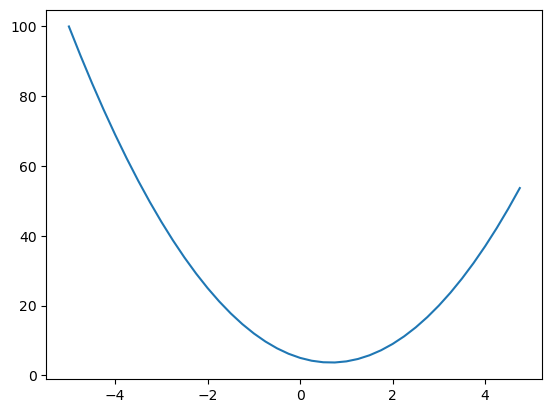

In [16]:
plt.plot(xs, ys)

In [17]:
h = 0.00000001
x = 3.0
(f(x+h)-f(x))/h
# derivative of 3x^2 - 4x + 5 = 6x-4 = 18-4 = 14
# this derivative is 0 at 2/3

14.00000009255109

In [18]:
# multiple scalars
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)
# lets look at the derivatives of d with respect to a/b/c

4.0


In [19]:
h = 0.001

# point (a,b,c) at which we're going to be evaluating d with respect to abc
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [52]:
# wraps a value
class Value:
    # `()` is an empty tuple
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # derivative of L with respect to this value
        # 0 means "no effect" (gradient 0)
        self.grad = 0.0
        self._prev = set(_children) # set is cheaper than tuple
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label='d' # (a.__mul__(b)).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L # "loss function"
# L is the value of the FORWARD PASS... -8

Value(data=-8.0)

In [39]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [40]:
d._op

'+'

In [41]:
d.label

'd'

In [53]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

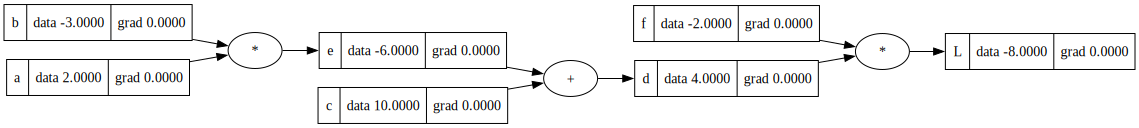

In [54]:
draw_dot(L) 

In [51]:
# now we want to "backpropagate"
# abcdef will eventually represent the weights of the neural net
# and we want to know how they impact the loss function L
#
# we are interested in the derivative of the output with respect to some of its leaf nodes
# and those lef nodes will be the weights
# ...and other leaf nodes will be the data itself
# usually we will not want/use the derivative of the loss function with respect to the data
# because the data is fixed
# but the weights will be iterated on